In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.annotated_peaks.tsv'
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr1,28975111,28975280,unfragmented.fwd_peak_2144,144234,2800.88940,14429.63574,14423.49805,6970.0,13,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
1,chr11,62609072,62609283,unfragmented.rvs_peak_18648,78235,1810.13269,7830.58057,7823.51221,3067.0,13,RNU2-2P,snRNA,-,.,Unannotated,0.0,0.0,Sense
2,chr1,17066862,17067191,unfragmented.fwd_peak_1267,73887,1625.85156,7395.16895,7388.78027,2749.0,13,RNU1-4,snRNA,+,RP5-1182A14.7,Long RNA,0.0,0.0,Sense
7,chr1,149223883,149224222,unfragmented.rvs_peak_6080,45232,1037.53625,4528.81104,4523.26758,2624.0,13,RNVU1-18,snRNA,-,.,Unannotated,0.0,0.0,Sense
9,chr1,17222326,17223168,unfragmented.fwd_peak_1274,38584,841.17084,3862.94019,3858.43213,2533.0,13,RNU1-2,snRNA,+,.,Unannotated,0.0,0.0,Sense


In [15]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

peak_df\
        .assign(peak_count = 1)\
        .groupby(['sense_gtype', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('sense_gtype').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .query('sense_gtype == "Long RNA"')

In [16]:
peak_df\
    .query('pileup >= %i & sample_count > %i' %(pileup_cutoff, sample_cutoff))\
    .query('sense_gtype == "Long RNA"')\
    .sort_values('pileup', ascending=False)\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_mt = lambda d: d.seq.map(is_mt))

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,is_mt
16,chr9,35657742,35658018,unfragmented.rvs_peak_108909,16844,418.20184,1690.65564,1684.48010,997.0,13,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,CGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGAC...,not_MT
18,chr14,20811226,20811576,unfragmented.rvs_peak_30602,15549,396.15240,1561.06494,1554.94873,973.0,13,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TTTCCCATAGGGCGGAGGGAAGCTCATCAGTGGGGCCACGAGCTGA...,not_MT
26,chr19,2271421,2271498,unfragmented.fwd_peak_53076,6172,75.46481,621.98541,617.29993,783.0,13,LLfos-48D6.2,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,CGGGGCCTCGGTGGTGCTCCTGATGCCCCTCACCCACCCCTGAAGA...,not_MT
48,chr4,91759630,91760266,unfragmented.rvs_peak_80207,1509,46.60136,156.16791,150.96947,146.0,13,AC019188.1,Long RNA,-,CCSER1,Long RNA,6.793444e-157,2.961007e-153,Sense,GACAACTCGGTGGTGGCCACTGCGCAGACCAGACTTCGCTCGTACT...,not_MT
71,chr11,5246693,5248342,unfragmented.rvs_peak_16440,887,29.78899,93.18472,88.78902,131.0,13,HBB,Long RNA,-,.,Unannotated,6.535518e-94,1.994011e-90,Sense,AGGGCTGGGCATAAAAGTCAGGGCAGAGCCATCTATTGCTTACATT...,not_MT
65,chr16,226352,227521,unfragmented.fwd_peak_40460,1106,40.71109,115.81686,110.69410,124.0,13,HBA1,Long RNA,+,.,Unannotated,1.524544e-116,5.028585e-113,Sense,AAAGGGTGGCGCTGCGCTCCGGGGTGCACGAGCCGACAGCGCCCGA...,not_MT
54,chr16,222645,223709,unfragmented.fwd_peak_40459,1304,47.51516,135.76463,130.41634,110.0,13,HBA2,Long RNA,+,.,Unannotated,1.719373e-136,6.768865e-133,Sense,CGGGATGGGCGGGAGTGGAGTGGCGGGTGGAGGGTGGAGACGTCCT...,not_MT
81,chrX,12994268,12995381,unfragmented.fwd_peak_121421,780,27.79118,83.10262,78.05936,103.0,13,TMSB4X,Long RNA,+,.,Unannotated,7.895507e-84,2.117757e-80,Sense,AGGCTGCGGGTCGGAGGGCAGAAGTGCAGTTCCCAGCCCAGAGACA...,not_MT
59,chr2,23574605,23574735,unfragmented.fwd_peak_58127,1185,40.42293,123.80553,118.51268,79.0,12,AC012506.2,Long RNA,+,.,Unannotated,1.564840e-124,5.616925e-121,Sense,TCTGCGGCCGGAGGCTCGCCTGCCGCATGCTCTCCTGCCAGGGCCA...,not_MT
178,chr1,149858481,149859516,unfragmented.fwd_peak_6687,382,15.26178,42.92898,38.20955,73.0,10,HIST2H2AC,Long RNA,+,HIST2H2AB,Long RNA,1.177660e-43,1.512878e-40,Sense,GCGAGGTTCTGAGCGTTGTCTGTGTTTAACCTTGATTTCAGTCATG...,not_MT


In [17]:
peak_df.sense_gtype.unique()

array(['snRNA', 'Long RNA', 'Unannotated', 'Repeats', 'snoRNA',
       'misc RNA', 'RBP', 'miRNA', 'piRNA', 'tRF3', 'rRNA', 'tRF5'],
      dtype=object)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_figure.pdf


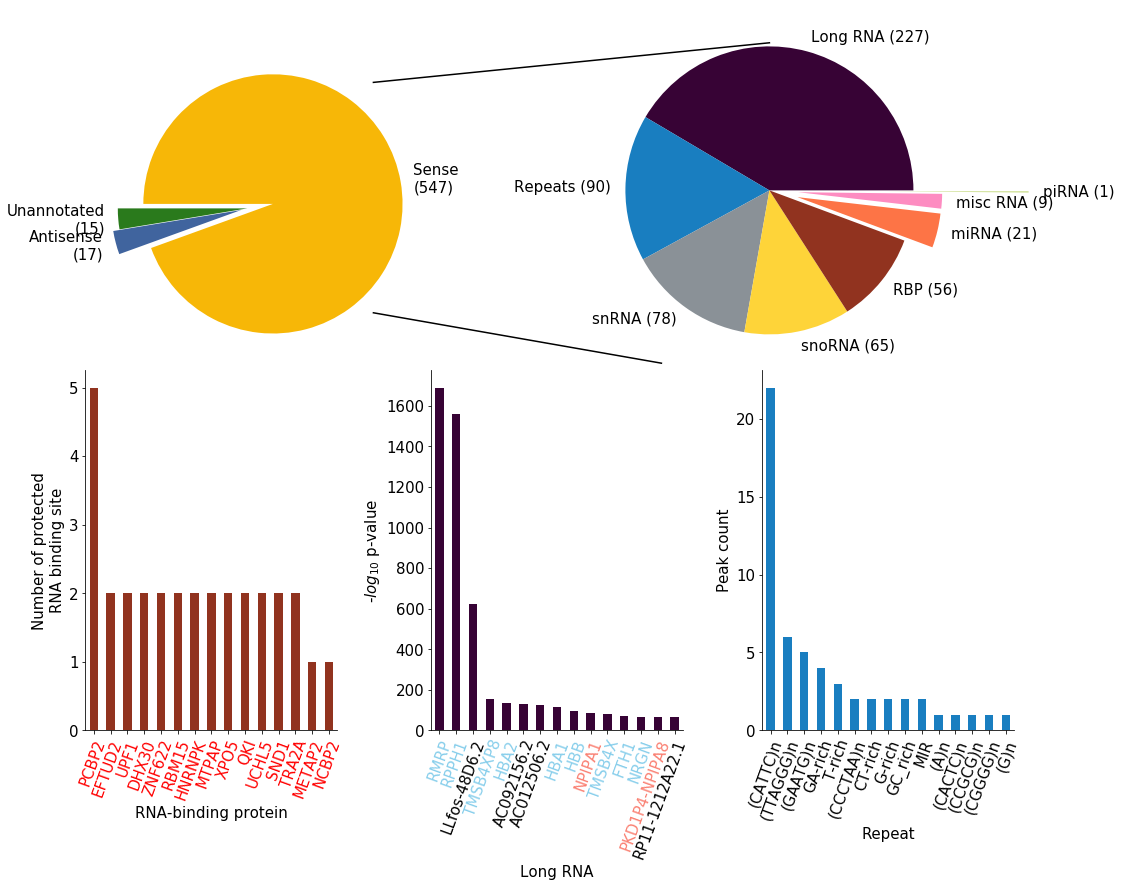

In [20]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
l1 = mlines.Line2D([0.3,0.85],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.7],[0.58,0.51], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [30]:
peak_df.shape

(244083, 18)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


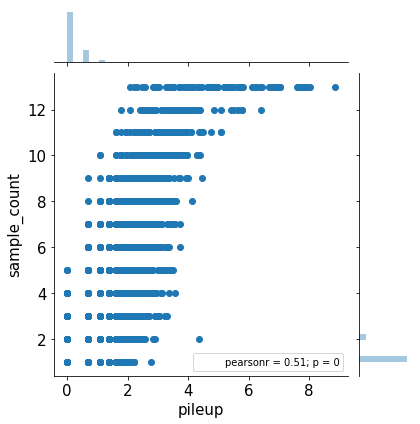

In [36]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [9]:
','.join(rbp_df.head(15).index)

'DDX3X,ILF3,SLTM,PRPF8,PPIG,ZNF622,BUD13,DDX6,UCHL5,RBM15,SRSF1,EFTUD2,XRN2,TRA2A,NKRF'

In [39]:
peak_df \
    .query('pileup >= %i & sample_count > %i' %(pileup_cutoff, sample_cutoff))\
    .query('sense_gtype == "RBP"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
22,chr19,11333579,11333670,unfragmented.rvs_peak_50752,9366,253.80643,942.69574,936.65271,299.0,13,EFTUD2,RBP,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
38,chr6,95156837,95156909,unfragmented.rvs_peak_93210,2889,84.71193,294.71451,288.96790,90.0,11,MTPAP,RBP,-,.,Unannotated,1.929701e-295,1.121446e-291,Sense
82,chr3,47459253,47459352,unfragmented.rvs_peak_71756,779,29.43539,81.54980,77.98944,81.0,12,PCBP2,RBP,-,.,Unannotated,2.819681e-82,7.400390e-79,Sense
105,chr11,63978545,63978746,unfragmented.fwd_peak_19964,583,21.35736,63.02992,58.34212,79.0,11,TRA2A,RBP,+,.,Unannotated,9.334262e-64,1.947295e-60,Sense
182,chr4,1315337,1315575,unfragmented.fwd_peak_82354,372,14.35504,40.62181,37.29104,53.0,9,UCHL5,RBP,+,.,Unannotated,2.388856e-41,2.789853e-38,Sense
161,chr1,16891326,16891410,unfragmented.rvs_peak_1132,409,20.96930,45.83349,40.96949,51.0,10,SMNDC1,RBP,-,.,Unannotated,1.467270e-46,2.034862e-43,Sense
276,chr11,65272588,65272969,unfragmented.fwd_peak_20107,228,9.16093,26.19619,22.89058,48.0,10,AUH,RBP,+,TALAM1,Long RNA,6.365170e-27,5.027928e-24,Sense
76,chr17,39913787,39913887,unfragmented.rvs_peak_44551,811,30.00123,86.48480,81.10771,32.0,13,XPO5,RBP,-,.,Unannotated,3.274915e-87,9.294779e-84,Sense
80,chr16,2149771,2149861,unfragmented.rvs_peak_38363,781,30.07980,83.57507,78.14968,31.0,10,EFTUD2,RBP,-,.,Unannotated,2.660296e-84,7.214812e-81,Sense
481,chr14,94847270,94847501,unfragmented.rvs_peak_33469,126,6.61739,15.82563,12.65839,29.0,10,TBRG4,RBP,-,.,Unannotated,1.494067e-16,6.420357e-14,Sense


In [11]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


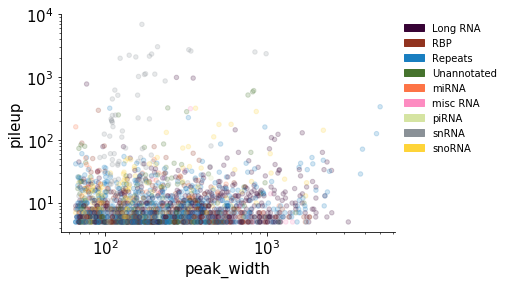

In [18]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


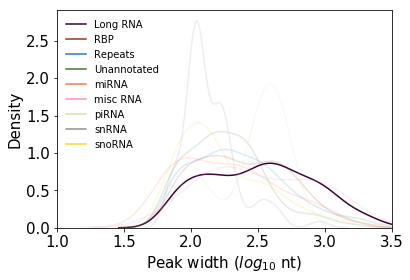

In [19]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: np.log10(d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 0.15
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,4, 0.5)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_qc.pdf


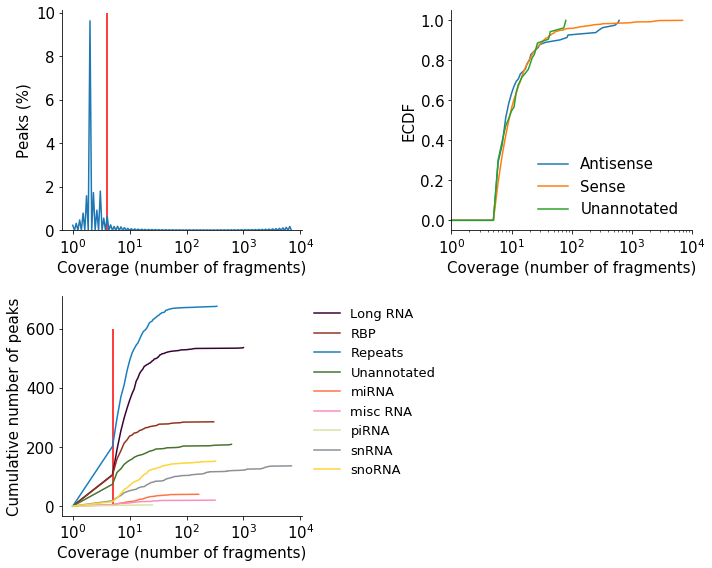

In [20]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)



In [22]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
16,chr9,35657742,35658018,unfragmented.rvs_peak_108909,16844,418.20184,1690.65564,1684.48010,997.0,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
18,chr14,20811226,20811576,unfragmented.rvs_peak_30602,15549,396.15240,1561.06494,1554.94873,973.0,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
26,chr19,2271421,2271498,unfragmented.fwd_peak_53076,6172,75.46481,621.98541,617.29993,783.0,LLfos-48D6.2,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
48,chr4,91759630,91760266,unfragmented.rvs_peak_80207,1509,46.60136,156.16791,150.96947,146.0,AC019188.1,Long RNA,-,CCSER1,Long RNA,6.793444e-157,2.961007e-153,Sense
54,chr16,222645,223709,unfragmented.fwd_peak_40459,1304,47.51516,135.76463,130.41634,110.0,HBA2,Long RNA,+,.,Unannotated,1.719373e-136,6.768865e-133,Sense
55,chr2,140977935,140978004,unfragmented.rvs_peak_59375,1267,41.59935,132.23700,126.72901,45.0,AC092156.2,Long RNA,-,.,Unannotated,5.794287e-133,2.209823e-129,Sense
59,chr2,23574605,23574735,unfragmented.fwd_peak_58127,1185,40.42293,123.80553,118.51268,79.0,AC012506.2,Long RNA,+,.,Unannotated,1.564840e-124,5.616925e-121,Sense
65,chr16,226352,227521,unfragmented.fwd_peak_40460,1106,40.71109,115.81686,110.69410,124.0,HBA1,Long RNA,+,.,Unannotated,1.524544e-116,5.028585e-113,Sense
71,chr11,5246693,5248342,unfragmented.rvs_peak_16440,887,29.78899,93.18472,88.78902,131.0,HBB,Long RNA,-,.,Unannotated,6.535518e-94,1.994011e-90,Sense
79,chr16,15027133,15027223,unfragmented.fwd_peak_41446,782,31.52192,83.73048,78.22795,32.0,RP11-958N24.1,Long RNA,+,.,Unannotated,1.860030e-84,5.101143e-81,Sense


In [29]:
anti_peaks.antisense_gtype.unique()

array(['Long RNA', 'RBP', 'snRNA', 'tRF3', 'tRF5', 'misc RNA', 'snoRNA',
       'piRNA', 'miRNA'], dtype=object)

In [30]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_anti.pdf


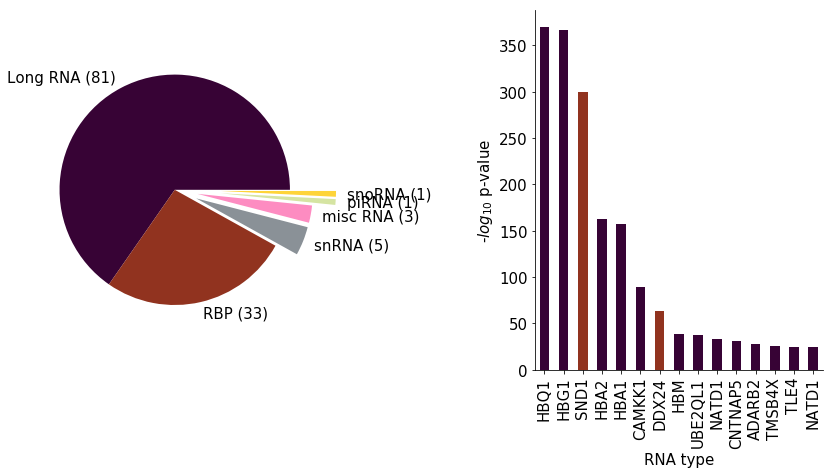

In [38]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [34]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [35]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

'TTTACCCAAATAAAGTATAGGTGATAGAAATTGTATCTTGACGCAATAGATATAGTACCGCAAGGGAAAGATGACAAAACATAACCAAGCATAAAATAG'

In [36]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(252, 23)

In [37]:
intron_df \
    .query('pileup >= 5' )

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,antisense_gtype,pvalue,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand
0,chr19,11333582,11333668,unfragmented.rvs_peak_50752,9366,253.80643,942.69574,936.65271,299.0,EFTUD2,...,Unannotated,0.000000e+00,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-
1,chr22,50356514,50356587,unfragmented.fwd_peak_74339,1242,42.22908,129.87506,124.23650,52.0,MIR6821,...,Unannotated,1.333337e-130,5.006845e-127,Sense,chr22,50356514,50356587,ENSG00000198355.4,0,+
2,chr17,39913789,39913885,unfragmented.rvs_peak_44551,811,30.00123,86.48480,81.10771,32.0,XPO5,...,Unannotated,3.274915e-87,9.294779e-84,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-
3,chr16,15027134,15027223,unfragmented.fwd_peak_41446,782,31.52192,83.73048,78.22795,32.0,RP11-958N24.1,...,Unannotated,1.860030e-84,5.101143e-81,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+
4,chr16,2149772,2149861,unfragmented.rvs_peak_38363,781,30.07980,83.57507,78.14968,31.0,EFTUD2,...,Unannotated,2.660296e-84,7.214812e-81,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-
5,chr16,18430618,18430707,unfragmented.rvs_peak_39282,590,24.21262,64.31211,59.06322,25.0,RP11-1212A22.1,...,Unannotated,4.874050e-65,1.052808e-61,Sense,chr16,18430618,18430707,ENSG00000214940.4,0,-
6,chr16,18470720,18470809,unfragmented.rvs_peak_39289,406,18.26798,45.83761,40.69362,18.0,RP11-1212A22.4,...,Unannotated,1.453416e-46,2.027167e-43,Sense,chr16,18470720,18470809,ENSG00000233024.3,0,-
7,chr17,73500562,73500652,unfragmented.rvs_peak_46298,386,16.94794,43.73572,38.62443,17.0,CASKIN2,...,Unannotated,1.837723e-44,2.411596e-41,Sense,chr17,73500562,73500652,ENSG00000177303.5,0,-
8,chr17,48216682,48216793,unfragmented.rvs_peak_45104,321,14.79634,37.17871,32.15405,15.0,PRPF8,...,Long RNA,6.626588e-38,7.063046e-35,Sense,chr17,48216682,48216793,ENSG00000108819.9,0,-
9,chr2,97529532,97529662,unfragmented.rvs_peak_57479,311,14.20104,36.17538,31.16733,15.0,LIN28B,...,Unannotated,6.677594e-37,7.025376e-34,Sense,chr2,97529532,97529662,ENSG00000168758.6,0,-


In [60]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,seq,dinucleotide
0,chr19,11333582,11333668,unfragmented.rvs_peak_7689,8779,245.78587,883.93384,877.97772,286.0,EFTUD2,...,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-,GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCG...,GT:AG
1,chr17,39913789,39913885,unfragmented.rvs_peak_6736,729,28.46350,78.24293,72.95807,30.0,XPO5,...,1.765379e-76,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-,GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCAC...,GT:AG
2,chr16,2149772,2149861,unfragmented.rvs_peak_5807,714,28.12118,76.77870,71.48138,28.0,EFTUD2,...,4.853330e-75,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-,GTGGGTGCCGTAGGGGTCGGGGCAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG
3,chr16,15027134,15027223,unfragmented.fwd_peak_6415,685,29.01322,73.82935,68.50440,30.0,RP11-958N24.1,...,4.185142e-72,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG
4,chr15,91423005,91423096,unfragmented.fwd_peak_6191,538,22.24964,59.07255,53.84354,23.0,XPO5,...,1.976857e-57,Sense,chr15,91423005,91423096,ENSG00000140564.6,0,+,GTGAGGGCAGGCTGGCCCGGCAGGCTGGATGTGGAGTTAGGTAGAA...,GT:AG


In [63]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/intron_table.csv


In [46]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,...,pvalue,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,length
count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'DataFrame' object has no attribute 'gid'

In [48]:
glist

NameError: name 'glist' is not defined

In [49]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



NameError: name 'glist' is not defined

NameError: name 'glist' is not defined

In [50]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

NameError: name 'peaks' is not defined

In [51]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

NameError: name 'peaks' is not defined

In [52]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

NameError: name 'peaks' is not defined

In [53]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

NameError: name 'peaks' is not defined

In [54]:
import gseapy as gsp

In [55]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

2018-09-09 18:07:22,999 Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-54e17a5d030f>", line 2, in <module>
    gene_sets = 'KEGG_2016')
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 953, in prerank
    pre.run()
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 432, in run
    gmt = self.load_gmt(gene_list=dat2.index.values, gmt=self.gene_sets)
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 93, in load_gmt
    genesets_dict = self.parse_gmt(gmt)
  File "/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/gseapy/gsea.py", line 138, in parse_gmt
    return self._download_libraries(gmt)
  File "/stor/work/Lambowitz/cdw2854/src/min

KeyboardInterrupt: 

In [ ]:
res.res2d

'ACCACGGCCGTTGAACATATGTCACTGGGCAGGCAGTGCCTCTACTACTGGTAATGCTAGCGGTGATGTTTTTGGTAAACAAGCTGGGTAAGATTTGCCGAGTTCCTTTTACTGTTTGTAATCTTTCCTTAGAGCATACCTGTGTTGGATTAACAGTAT'

In [131]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [132]:
print(next(aln))

0	148	-	chrM	16569	2426	2575	135	149	40	tp:A:P	ts:A:.	cg:Z:17M1D131M


In [40]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [42]:
anti = peak_df.query('pileup >= 5').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

82 seq: 4 in MT


In [44]:
peak_df.query("sense_gtype == 'tRF3'")

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
28026,chr1,238104447,238104679,unfragmented.fwd_peak_10673,24,2.66633,5.63692,2.40724,3.0,tRNA-Tyr-ATA-chr1-52-tRF3,tRF3,+,.,Unannotated,2.307172e-06,0.000016,Sense
5158,chr17,29877164,29877510,unfragmented.fwd_peak_46762,37,3.55599,7.41424,3.70360,3.0,tRNA-Thr-CGT-4-1-tRF3,tRF3,+,.,Unannotated,3.852654e-08,0.000001,Sense
109732,chr17,8022548,8022717,unfragmented.fwd_peak_45744,11,1.96892,3.90910,1.16075,1.0,tRNA-Lys-TTT-3-5-tRF3,tRF3,+,.,Unannotated,1.232821e-04,0.000231,Sense
